<a href="https://colab.research.google.com/github/itberrios/CV_projects/blob/main/mars_challenge/mars_challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mars Challenge**

The [MARS Challenge](https://blog.marsauto.com/introducing-the-mars-challenge-fc84c5afafbe) involves estimated the velocity of an ego camera mounted on a vehicel using only video (with train and test splits)

We will attempt the MARS challenge with a simple approach

1. Compute Camera Motion Compension transformation matrix
2. Use Transformation Matrix and true speed values to train a model that will regress the velocity


We will train multiple baseline models and compare their performances. However, we will avoid ensembling since we are interested in real time applications. Let's get started!

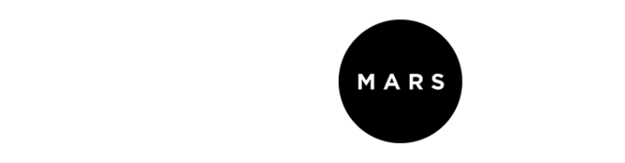

Download the data

In [1]:
!wget https://marschallenge.s3.ap-northeast-2.amazonaws.com/train.mp4
!wget https://marschallenge.s3.ap-northeast-2.amazonaws.com/train.txt
!wget https://marschallenge.s3.ap-northeast-2.amazonaws.com/test.mp4

test.mp4            100%[===================>] 399.79M  15.1MB/s    in 29s     

2023-08-26 22:15:27 (13.9 MB/s) - ‘test.mp4’ saved [419215517/419215517]



### **Import Libraries**

In [3]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

### **Set up pipeline to collect transformation matrices for each frame pair**

In [4]:
def compute_motion(frame1 : np.ndarray,
                   frame2 : np.ndarray,
                   method : int,
                   params : dict) -> np.ndarray:
    """
    Computes motion compensation transformation matrix (a rigid body transform)
    from frame 1 to frame 2
    Inputs:
      frame 1 - first grayscale frame
      frame 2 - second grayscale frame
      method - determines the method of feature detection
      params - parameters for feature detection
    Outputs:
      A - 2x3 Affine Transformation matrix that maps frame1 to frame2
      prev_points - key points in frame 1
      curr_points - matched key points in frame 2
    """

    # get corners of first image
    if method == 0:
        fast = cv2.FastFeatureDetector_create(**params)
        corners = cv2.KeyPoint_convert(fast.detect(frame1, None))
    elif method == 1:
        corners = cv2.goodFeaturesToTrack(frame1, **params)

    # get matching features on next image
    matched_corners, status, error = cv2.calcOpticalFlowPyrLK(frame1, frame2, corners, None)

    # get valid matched features
    status = status.reshape((-1))
    prev_points = corners.reshape((-1, 2))[status==1]
    curr_points = matched_corners.reshape((-1, 2))[status==1]

    # estimate transformation matrix from frame 1 to frame 2
    A, _ = cv2.estimateAffinePartial2D(prev_points, curr_points, method=cv2.RANSAC)

    return A, prev_points, curr_points

Set Parameters

In [ ]:
# FAST (larger threshold --> fewer features )
params_0 = {'threshold' : 10}

# Shi-Thomasi
params_1 = {'maxCorners' : 500,
            'qualityLevel' : 0.01,
            'minDistance' : 10}


Stream video and get training features

In [23]:
cap = cv2.VideoCapture("train.mp4")

if (cap.isOpened() == False):
    print("Error opening video file")

X = []
prev_frame = None
i = 0
while(cap.isOpened()):

    # read each video frame
    ret, frame = cap.read()

    if ret == True:
        if i > 0:
          gray1 = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
          gray2 = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
          A, _, _ = compute_motion(gray1, gray2, method=0, params=params_0)

          # update features (transpose allows for separation of rot and trans)
          X.append(A.T.flatten())

        # update previous frame
        prev_frame = frame.copy()

        # increment counter
        i += 1

    # Break if nothing is returned
    else:
        break

# clean up
cap.release()
cv2.destroyAllWindows()

Store feature array in .txt file

In [40]:
# place in array and account for first frame
X = np.vstack((np.zeros(6), np.array(X)))
print(X.shape)

np.savetxt('train_X.txt', X)

# convert back to 2x3 Transformation Matrix
# X[-1, :].reshape((3,2)).T

(8100, 6)


The training data that we have just aquired consists of the Camera Motion Compensation transformation for speed at each time stamp (except the first).

## **Break into train, valid, test splits**


In [45]:
# load target variable (speeds)
y = np.loadtxt('train.txt')

# neglect first training sample
y = y[1:]
X = X[1:, :]

print(X.shape, y.shape)

(8099, 6) (8099,)


In [73]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [74]:
X_train.shape, X_valid.shape, X_test.shape

((6479, 6), (810, 6), (810, 6))

## **Study the Collected Features**

In [77]:
A

array([[ 9.95056562e-01, -9.76278689e-04,  1.62505803e+00],
       [ 9.76278689e-04,  9.95056562e-01, -4.61654648e+00]])

In [78]:
X[-1, :]

array([ 9.95056562e-01,  9.76278689e-04, -9.76278689e-04,  9.95056562e-01,
        1.62505803e+00, -4.61654648e+00])

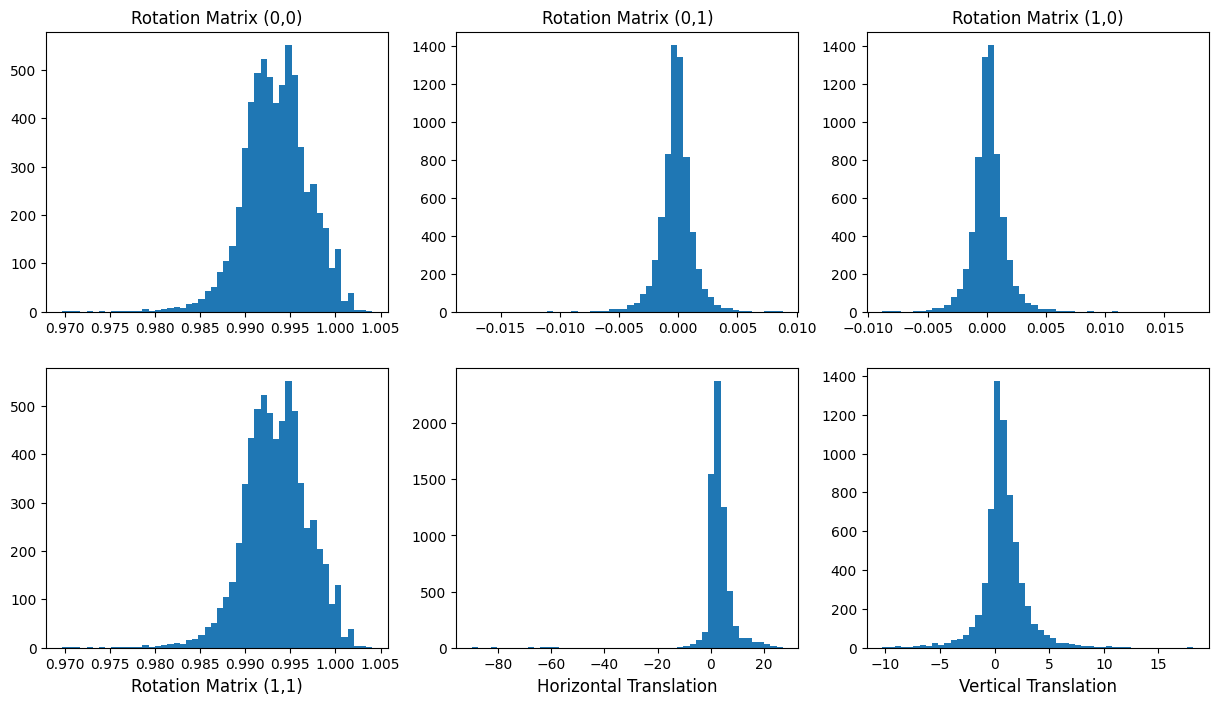

In [91]:
_, ax = plt.subplots(2, 3, figsize=(15, 8))
ax[0, 0].hist(X_train[:, 0], bins=50)
ax[0, 0].set_title("Rotation Matrix (0,0)", size=12)
ax[0, 1].hist(X_train[:, 1], bins=50)
ax[0, 1].set_title("Rotation Matrix (0,1)", size=12)
ax[0, 2].hist(X_train[:, 2], bins=50)
ax[0, 2].set_title("Rotation Matrix (1,0)", size=12)
ax[1, 0].hist(X_train[:, 3], bins=50)
ax[1, 0].set_xlabel("Rotation Matrix (1,1)", size=12)
ax[1, 1].hist(X_train[:, 4], bins=50)
ax[1, 1].set_xlabel("Horizontal Translation", size=12)
ax[1, 2].hist(X_train[:, 5], bins=50)
ax[1,2].set_xlabel("Vertical Translation", size=12);


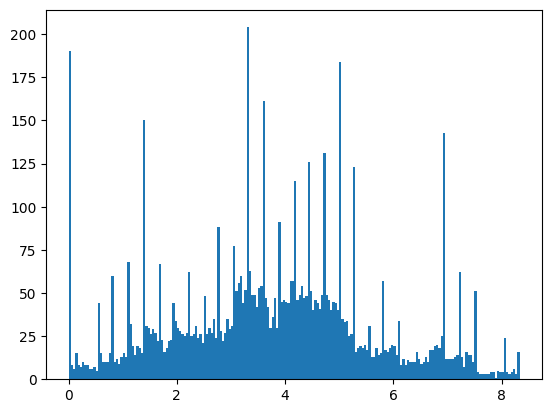

In [97]:
plt.hist(y_train, bins=200);

We will operate under the assumption that large outliers are due to large object motion and not camera motion. We further assume that true camera motion is very small and incremental. Because of these assumptions, we will not normalize the data.

In [255]:
from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train.reshape((-1, 1)))

In [256]:
# test scaler
x_scaler.transform(X_train).mean(axis=0), x_scaler.transform(X_train).std(axis=0)

(array([-3.38995051e-13,  4.04874124e-17, -4.04874124e-17, -3.38995051e-13,
        -4.96978597e-17, -7.27839527e-16]),
 array([1., 1., 1., 1., 1., 1.]))

In [249]:
# test inverse scaler
X_train.mean(axis=0), X_train.std(axis=0)

(array([ 9.93417451e-01, -1.82737179e-04,  1.82737179e-04,  9.93417451e-01,
         3.14287375e+00,  8.19073013e-01]),
 array([3.54570887e-03, 1.43928942e-03, 1.43928942e-03, 3.54570887e-03,
        5.98985173e+00, 2.04217432e+00]))

In [257]:
x_scaler.inverse_transform(x_scaler.transform(X_train)).mean(axis=0), x_scaler.inverse_transform(x_scaler.transform(X_train)).std(axis=0)

(array([ 9.93417451e-01, -1.82737179e-04,  1.82737179e-04,  9.93417451e-01,
         3.14287375e+00,  8.19073013e-01]),
 array([3.54570887e-03, 1.43928942e-03, 1.43928942e-03, 3.54570887e-03,
        5.98985173e+00, 2.04217432e+00]))

# **Build Baseline Models**

For this tutorial we will build a few baseline models
- Linear Model
- Neural Network
- Support Vector Machine
- Random Forest
- XGBoost

In [119]:
import xgboost as xgb
from sklearn.linear_model import ElasticNet
from sklearn import svm


enet = ElasticNet(alpha=0.08, l1_ratio=0.05)
svr = svm.SVR()

xgb_rf = xgb.XGBRFRegressor()
xgbr = xgb.XGBRegressor()

Build neural network

In [283]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(6, 10)
        self.fc2 = nn.Linear(10, 4)
        self.fc3 = nn.Linear(4, 1)

    def forward(self, x):
        # x1 = F.relu(self.fc1(x))
        # x2 = F.relu(self.fc2(x1))
        # x3 = F.relu(self.fc3(x2 + x1))

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        return x


net = Net()
print(net)

# test pass
# net(torch.rand(32, 6))

Net(
  (fc1): Linear(in_features=6, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=1, bias=True)
)


### **Train models**

In [291]:
# scale data
X_train_s = x_scaler.transform(X_train)
y_train_s = y_scaler.transform(y_train.reshape((-1, 1)))
X_valid_s = x_scaler.transform(X_valid)
y_valid_s = y_scaler.transform(y_valid.reshape((-1, 1)))


enet.fit(X_train_s, y_train_s)
print("Elastic Net fit complete")

svr.fit(X_train_s, y_train_s)
print("Support Vector Machine Regressor fit complete")

xgb_rf.fit(X_train_s, y_train_s)
print("Random Forest fit complete")

xgbr.fit(X_train_s, y_train_s)
print("XGBoost fit complete")

Elastic Net fit complete


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Support Vector Machine Regressor fit complete
Random Forest fit complete
XGBoost fit complete


Train Neural Network

In [284]:
from torch.utils.data import Dataset, DataLoader


class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x,y

    def __len__(self):
        return len(self.data)


train_dataset = CustomDataset(x_scaler.transform(X_train),
                              y_scaler.transform(y_train.reshape((-1, 1))))
valid_dataset = CustomDataset(x_scaler.transform(X_valid),
                              y_scaler.transform(y_valid.reshape((-1, 1))))

trainloader = DataLoader(train_dataset, batch_size=32)
validloader = DataLoader(valid_dataset, batch_size=32)

In [285]:
import torch.optim as optim

criterion = nn.MSELoss()
# optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.005)
optimizer = optim.Adam(net.parameters(), lr=0.03)

In [286]:
train_loss = []
valid_loss = []
for e in range(100):

    # train loop
    train_losses = []
    for x,y in trainloader:
        # cast to float32
        x, y = x.to(torch.float), y.to(torch.float)

        y_pred = net(x)
        loss = torch.sqrt(criterion(y, y_pred))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.detach().numpy())

    # update loss
    train_loss.append(np.sum(train_losses)/len(trainloader))


    # validation loop
    valid_losses = []
    with torch.no_grad():
        for x,y in validloader:
            # cast to float32
            x, y = x.to(torch.float), y.to(torch.float)

            y_pred = net(x)
            loss = torch.sqrt(criterion(y, y_pred))

            valid_losses.append(loss.detach().numpy())

        valid_loss.append(np.sum(valid_losses)/len(validloader))

    # print progress
    print(f"Epoch: {e+1} - train loss: {train_loss[-1]} - valid loss: {valid_loss[-1]}")

Epoch: 1 - train loss: 0.9401401463400554 - valid loss: 0.9736565076387845
Epoch: 2 - train loss: 0.9043353602216748 - valid loss: 0.9474897384643555
Epoch: 3 - train loss: 0.8962668432977986 - valid loss: 0.9451274138230544
Epoch: 4 - train loss: 0.8942988353409791 - valid loss: 0.9440398583045373
Epoch: 5 - train loss: 0.8937304266567888 - valid loss: 0.9446031130277194
Epoch: 6 - train loss: 0.8946712099272629 - valid loss: 0.9430912457979642
Epoch: 7 - train loss: 0.8921929721174569 - valid loss: 0.9459952574509841
Epoch: 8 - train loss: 0.8958394468711515 - valid loss: 0.9450776760394757
Epoch: 9 - train loss: 0.8943856525890933 - valid loss: 0.9463489239032452
Epoch: 10 - train loss: 0.8917010077114763 - valid loss: 0.9429085071270282
Epoch: 11 - train loss: 0.8902669822053956 - valid loss: 0.9422786419208233
Epoch: 12 - train loss: 0.8911890490301724 - valid loss: 0.9402982271634616
Epoch: 13 - train loss: 0.8905143549876847 - valid loss: 0.9444421621469351
Epoch: 14 - train los

## **Validate Models**

In [294]:
from sklearn.metrics import mean_squared_error

# Elastic Net
y_valid_enet_preds = enet.predict(X_valid_s)

enet_valid_rmse = mean_squared_error(y_valid_s, y_valid_enet_preds)
print(f"Elastic Net validation RMSE: {enet_valid_rmse}")

# Support Vector Regressor
y_valid_svr_preds = svr.predict(X_valid_s)

svr_valid_rmse = mean_squared_error(y_valid_s, y_valid_svr_preds)
print(f"SVR validation RMSE: {svr_valid_rmse}")

# Random Forest
y_valid_rf_preds = xgb_rf.predict(X_valid_s)

rf_valid_rmse = mean_squared_error(y_valid_s, y_valid_rf_preds)
print(f"Random Forest validation RMSE: {rf_valid_rmse}")

# XG Boost
y_valid_xgb_preds = xgbr.predict(X_valid_s)

xgb_valid_rmse = mean_squared_error(y_valid_s, y_valid_xgb_preds)
print(f"XG Boost validation RMSE: {xgb_valid_rmse}")

Elastic Net validation RMSE: 0.805707593960841
SVR validation RMSE: 0.5342344627755359
Random Forest validation RMSE: 0.4655884538571152
XG Boost validation RMSE: 0.43725145022490336


## **Focus on Random Forest and XG Boost**

In [311]:
xgb_rf = xgb.XGBRFRegressor(
    n_estimators=100,
    # max_depth=5,
    # max_leaves=0,
    # learning_rate=0.8,
    # reg_alpha=0.001,
    reg_lambda=0.001,
    # gamma=0,
    random_state=0
    )
xgbr = xgb.XGBRegressor(
    n_estimators=100,
    # max_depth=5,
    # random_state=0,
    # max_leaves=0,
    # learning_rate=0.8,
    # reg_alpha=0.001,
    reg_lambda=0.001,
    # gamma=0,
    random_state=0
    )

Baseline performance:
  - Random Forest validation RMSE: 0.4645639643722361
  - XG Boost validation RMSE: 0.42891753740490174

In [312]:
xgb_rf.fit(X_train_s, y_train_s)
print("Random Forest fit complete")

xgbr.fit(X_train_s, y_train_s)
print("XGBoost fit complete")

Random Forest fit complete
XGBoost fit complete


In [313]:
# Random Forest
y_valid_rf_preds = xgb_rf.predict(X_valid_s)

rf_valid_rmse = mean_squared_error(y_valid_s, y_valid_rf_preds)
print(f"Random Forest validation RMSE: {rf_valid_rmse}")

# XG Boost
y_valid_xgb_preds = xgbr.predict(X_valid_s)

xgb_valid_rmse = mean_squared_error(y_valid_s, y_valid_xgb_preds)
print(f"XG Boost validation RMSE: {xgb_valid_rmse}")

Random Forest validation RMSE: 0.4645127399955221
XG Boost validation RMSE: 0.4444739458570942
